# Final Project - Synthesizing Geospatial Analysis Workflow

In this final module, you are tasked with executing a geospatial analysis workflow that will incorporate many of the analysis skills that have been covered throughout the course.

### Load relevant libraries

Documentation of these packages can be found at: 

-https://cran.r-project.org/web/packages/classInt/classInt.pdf

-https://cran.r-project.org/web/packages/rgdal/rgdal.pdf  

-https://cran.r-project.org/web/packages/spdep/spdep.pdf

-https://cran.r-project.org/web/packages/geoR/geoR.pdf

In [533]:
# Load relevant R packages
inLibraries = list('repr','rgeos','rgdal','spdep','gstat','classInt','geoR','GISTools','sp','raster', 'RColorBrewer')
for (rpack in inLibraries) {
  if (is.element(rpack,installed.packages()[,1])){           
      #Load the library into R
      suppressMessages(library(rpack,character.only = TRUE))
    }
    else {
        print(paste("Warning:  ",rpack," is not an installed package"))
    }
}
#resize plot area
options(repr.plot.width=6, repr.plot.height=6)

## Vehicle Crash Data

In this final project, you are to work with vehicle crash data for the state of Indiana. The dataset (indianacrashes/Dec2013Crashes.shp) is a point featureclass representing crash locations reported in December 2013. The dataset (indianacrashes/INRoads) is a line featureclass representing HPMS (https://www.fhwa.dot.gov/policyinformation/hpms/fieldmanual/HPMS_2014.pdf) road data.

In this project, the goal is to analyze vehicle crashes.  Vehicle crashes can be analyzed at the individual or point level (i.e. the different locations of the crashes), at the road or line level (i.e. as aggregated to the different road segments in a region), or at an area level (i.e. as aggregated to some polygon analysis area). I've provided you with the point data (Dec2013Crashes.shp).  However, I'd like you aggregate the crash data to the road segments that have been provided.  Also, I'd like you to aggregate the crash data to three different polygon-based representations of the region.  Task Set A will focus on this data preparation effort.

In Task Set B, the focus will be on conducting analysis at different levels of aggregation. 

In this task set, you have lots of freedom as to how to proceed. 

At this point, you should have point-based crashes, line-based crashes, and 3 polygon-based representations of crashes.

You must pick at least 3 different geographic representations of the crash data for the analysis. 

At least 2 of these 3 must be of different data types (i.e. point and polygons; polygons and line; point and line;point,line and polygon).  

Then for each of the 3 datasets you select, you should apply a set of geospatial analyses to the data.  You can accomplish this in a range of ways.  

For example, one option could be to apply the same general set of analysis to each of the three datasets and then compare the results to understand the impact of MAUP. 

Another option might be to conduct a separate set of analyses on each dataset to evaluate a different facet of vehicle accidents. 

You are free to using any of the methods described in the course or any other geospatial techniques that you may have come across.  Although there are no limits to the number of analyses you can apply to the datasets, you should attempt at least two.  

Although there are many assumptions that are involved in applying many of the analysis methods covered in the course, there is no need to be overly concerned with them in this final project. The major point of this practice is to get some experience integrating geospatial methods in a logical workflow.  Ensuring that all assumptions have been met prior to and during the application of a method typically much more time than we have for this project.  Moreover, I'd rather you spend more time exploring potential methods and hopefully find some interesting applications (even if they may not be 100% justifiable).  For example, if the data do not reflect a normal distribution and the method you want to implement requires that assumption to be met, you could either apply a simple transformation or proceed without transforming but detailing that decision in the summary at the end of the notebook.

To begin, you'll first want to look over the attributes of the crash and road datasets to see what's available for analysis. Of course, you are free to use other sources of data as well. For example, we've used some nation-wide county level data (i.e. the US farming and US county datasets) that could be of use. If you find any other geospatial information that could be helpful to you or others in the class, let me know and I can try and upload that as well.

## TASK SET A:  DATA PROCESSING

The first set of tasks is related to data preparation.

**Task 1:** Read in the crash locations and road features. Also, read in the transportation analysis zones (indianacrashes/INTAZ.shp) which could be helpful in subsetting the data later on. As you read in the data, it would be good to store the datasets in a list that could be referenced in subsequent tasks.

In [534]:
# (indianacrashes/Dec2013Crashes.shp

crashes <- readOGR("/dsa/data/geospatial/DS8612/indianacrashes", "Dec2013Crashes")

OGR data source with driver: ESRI Shapefile 
Source: "/dsa/data/geospatial/DS8612/indianacrashes", layer: "Dec2013Crashes"
with 12283 features
It has 28 fields


In [535]:
# indianacrashes/INRoads

roads <- readOGR("/dsa/data/geospatial/DS8612/indianacrashes", "INRoads")

OGR data source with driver: ESRI Shapefile 
Source: "/dsa/data/geospatial/DS8612/indianacrashes", layer: "INRoads"
with 21270 features
It has 70 fields


Warning message in readOGR("/dsa/data/geospatial/DS8612/indianacrashes", "INRoads"):
“Z-dimension discarded”

In [536]:
# indianacrashes/INTAZ.shp

tranzones <- readOGR("/dsa/data/geospatial/DS8612/indianacrashes", "INTAZ")

OGR data source with driver: ESRI Shapefile 
Source: "/dsa/data/geospatial/DS8612/indianacrashes", layer: "INTAZ"
with 6218 features
It has 12 fields


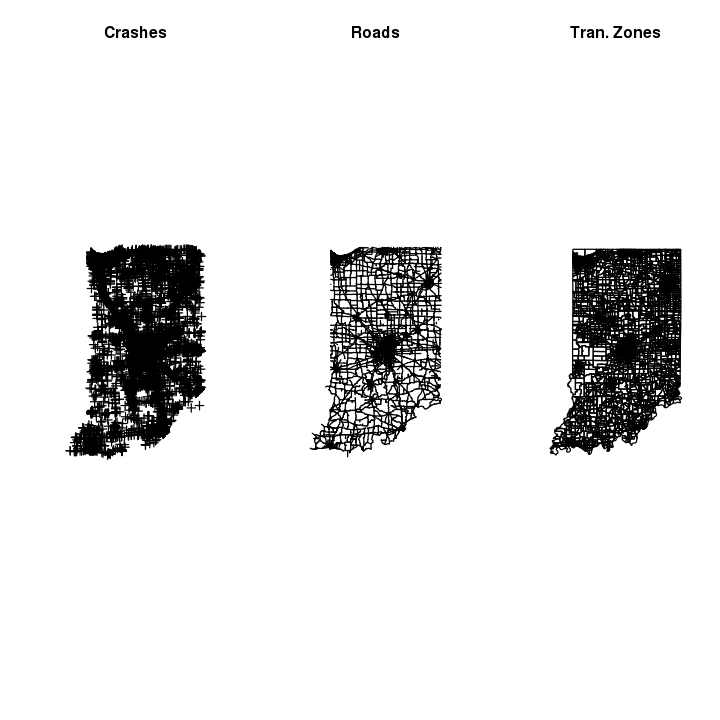

In [537]:
par(mfrow = c(1,3))

plot(crashes, main = "Crashes", axes = FALSE)
plot(roads, main = "Roads", axes = FALSE)
plot(tranzones, main = "Tran. Zones", axes = FALSE)

**Task 2:** Select a region appropriate CRS with measurement units in meters. 

Develop code that iterates over all of the input datasets, compares the CRS of the input datasets with that of the selected regionally appropriate CRS, and if the CRSs differ, transforms the CRS of the datasets into a region-appropriate CRS. 

In [538]:
newCRS <- CRS("+init=epsg:32616 +proj=utm +zone=16 +datum=WGS84 +units=m +no_defs +ellps=WGS84 +towgs84=0,0,0")
CRSargs(newCRS)

[1] "+init=epsg:32616 +proj=utm +zone=16 +datum=WGS84 +units=m +no_defs +ellps=WGS84 +towgs84=0,0,0"

In [539]:
oldList <- list(crashes, roads, tranzones)
newList <- list()

i <- 1

for (old in oldList){   
    oldCRS <- proj4string(old)
    if (oldCRS != CRSargs(newCRS)){
        new <- spTransform(old, newCRS)
        print(proj4string(new))
        newList[[i]] <- new        
        i <- i + 1
    }
}

[1] "+init=epsg:32616 +proj=utm +zone=16 +datum=WGS84 +units=m +no_defs +ellps=WGS84 +towgs84=0,0,0"
[1] "+init=epsg:32616 +proj=utm +zone=16 +datum=WGS84 +units=m +no_defs +ellps=WGS84 +towgs84=0,0,0"
[1] "+init=epsg:32616 +proj=utm +zone=16 +datum=WGS84 +units=m +no_defs +ellps=WGS84 +towgs84=0,0,0"


In [540]:
length(newList)

[1] 3

In [541]:
crashes.crs <- newList[[1]]
roads.crs <- newList[[2]]
tranzones.crs <- newList[[3]]

**Task 3:** 

While these datasets are not really that large, they are large enough to give jupyterhub a hard time. 

Thus, it may be good to take a smaller sample of the roads/crashes to use to avoid troubleshooting using the larger dataset....however, this is only a suggestion. 

To assist with this, the TAZ areas for Indiana have been included (indianacrashes/INTAZ). 

Every TAZ has a county attribute which could be used to query TAZs for a set of counties. 

For example, you might consider implementing the tasks for a contiguous 3-8 county area of the state. 

Remember too that we've used some other county-based data in the prior modules that you could use if desired. 

Of course, if you want to use the entire dataset, that's fine...you can skip this step...just realize it could be slow on jupyterhub.

In [542]:
head(tranzones.crs@data)

,STATEFP10,COUNTYFP10,MPOCE10,TADCE10,TAZCE10,GEOID10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10
0,18,175,18000000,00000036,00088031,1817500088031,G6320,S,12518886,51660,+38.5394454,-086.1167199
1,18,175,18000000,00000036,00088029,1817500088029,G6320,S,31310925,66055,+38.5012923,-086.2833819
2,18,175,18000000,00000036,00088039,1817500088039,G6320,S,3048619,4329,+38.5609836,-086.2574357
3,18,175,18000000,00000036,00088019,1817500088019,G6320,S,64261393,101767,+38.6058447,-086.2757908
4,18,175,18000000,00000035,00088018,1817500088018,G6320,S,49201544,226024,+38.6974316,-086.2818823
5,18,175,18000000,00000035,00088010,1817500088010,G6320,S,105464440,1240749,+38.6933729,-086.2013597


In [543]:
length(tranzones.crs)

[1] 6218

In [544]:
tranzones.subset <- tranzones.crs[200, ]
length(tranzones.subset)  

[1] 1

In [545]:
# add a buffer to that subsetted polygon
# then figure out which counties are inside that buffer.

buffer <- gBuffer(tranzones.subset, byid = TRUE, 
                                   id = NULL, width = 120000, quadsegs = 5, capStyle = "ROUND", 
                                      joinStyle = "ROUND", mitreLimit = 1.0)

intersect <- overGeomGeom(buffer, tranzones.crs, returnList = TRUE, fn = NULL)
intersect <- unlist(intersect)
tranzones.subset <- tranzones.crs[intersect, ]

In [546]:
intersect2 <- overGeomGeom(buffer, crashes.crs, returnList = TRUE, fn = NULL)
intersect2 <- unlist(intersect2)
crashes.subset <- crashes.crs[intersect2, ]

In [547]:
intersect3 <- overGeomGeom(buffer, roads.crs, returnList = TRUE, fn = NULL)
intersect3 <- unlist(intersect3)
roads.subset <- roads.crs[intersect3, ]

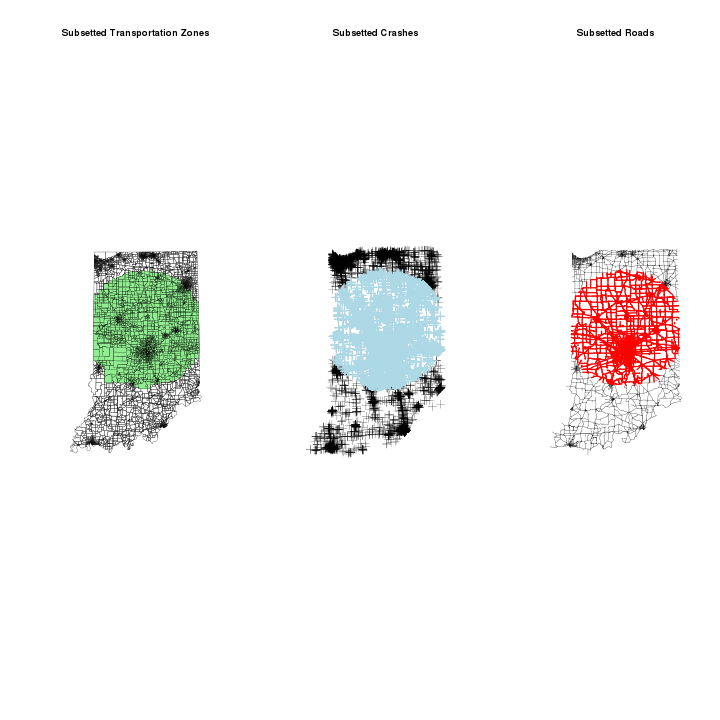

In [548]:
par(mfrow = c(1,3))

plot(tranzones.crs, main = "Subsetted Transportation Zones", lwd = 0.2, cex.main = 0.7)
plot(tranzones.subset, col = "lightgreen", add = TRUE, lwd = 0.2)

plot(crashes.crs, main = "Subsetted Crashes", lwd = 0.2, cex.main = 0.7)
plot(crashes.subset, col = "lightblue", add = TRUE)

plot(roads.crs, main = "Subsetted Roads", lwd = 0.2, cex.main = 0.7)
plot(roads.subset, col = "red", add = TRUE)

**Task 4:** Develop code that iterates over the input datasets, checks for a field named 'road.id' (in the road dataset) and one named 'crash.id' (in the crash dataset) and one named 'LENGTHMETER' (in both datasets).  

If the .id field is present (in the road and crash data), set the values to be an unique integer index for each feature. 

If the .id field is not present, add the field and assign each feature an unique id.  

If the 'LENGTHMETER' field is not present, add it and set the value for each feature to be the length of the feature in meters. 

Hint: The rgeos library will be of use here.

In [549]:
fields <- c("road.id", "crash.id")
subsets <- list(roads.subset, crashes.subset)

In [550]:
resList <- list()

for (i in 1:2){
    s <- subsets[[i]]
    colnames <- colnames(s@data)    
    numRows <- nrow(s@data)
    
    if (!("LENGTHMETER" %in% colnames)){
        
        lengths <- list()
        for (j in 1:numRows){
            lengths[[j]] <- gLength(s[j, ])
        }
        
        s@data$LENGTHMETER <- lengths
    }
    
    if (i == 1){
        if ("road.id" %in% colnames){
            s$road.id <- seq.int(nrow(s@data))
        }
        else{
            s$road.id <- seq.int(nrow(s@data))
        }
    }
    else{
        if ("crash.id" %in% colnames){
            s$crash.id <- seq.int(nrow(s@data))
        }
        else{
            s$crash.id <- seq.int(nrow(s@data))
        }
    }
    
    resList[[i]] <- s    
}

In [551]:
roads.subset <- resList[[1]]
head(roads.subset@data)

,YEAR_RECOR,STATE_CODE,BEG_POINT,END_POINT,F_SYSTEM,URBAN_CODE,FACILITY_T,THROUGH_LA,AADT,VOLUME_GRO,⋯,FAULTING,CRACK_PCT,CRACK_LEN,RouteID,FrMeasure,ToMeasure,SideOfRoad,Length,LENGTHMETER,road.id
0,2012,18,11.311,12.570,5,99999,2,4,6534,4,⋯,0.0,17,105.472,401,8781.3,15450.8,L,6669.48945,2032.122,1
2,2012,18,15.590,16.570,1,41212,2,6,105514,9,⋯,0.1,0,74.453,43,57313.5,62575.0,L,5261.47960,1603.097,2
3,2012,18,3.020,4.000,4,99999,2,2,3584,3,⋯,0.0,7,74.910,46087,0.0,5174.5,R,5174.49719,1576.566,3
5,2012,18,6.187,6.425,1,99999,2,4,47444,7,⋯,0.0,12,119.548,9,103976.6,105234.0,R,1257.37911,383.1085,4
7,2012,18,2.600,2.610,1,99999,2,4,30266,6,⋯,0.0,0,56.800,17,48422.2,48474.8,R,52.51993,16.02642,5
8,2012,18,0.000,8.650,4,99999,2,2,2404,3,⋯,0.1,26,104.898,39213,0.0,2557.2,R,2557.22233,779.1458,6


In [552]:
crashes.subset <- resList[[2]]
head(crashes.subset@data)

,COUNTYCDE,TOWNSHIPCD,CITYCDE,COLLDTE,COLLDAYWEE,COLLTIMETX,COLLTIMEAM,COLLTIMEMI,MOTORVEHIN,INJUREDNMB,⋯,MEDIANTYPE,RDWYJUNCTI,RDWYCHARCD,SURFACETYP,PRIMARYFAC,DAMAGEESTI,MANNERCOLL,lat,LENGTHMETER,crash.id
2,135,83942,84752,20131218,4,1130,A,1130,2,0,⋯,4,1,1,1,25,3,12,40.16505,0,1
7,177,81944,64260,20131221,7,0345,P,1545,2,0,⋯,4,1,1,1,29,3,2,39.82922,0,2
10,135,83942,84752,20131227,6,0216,P,1416,2,0,⋯,4,1,1,1,7,4,7,40.16558,0,3
16,1,65862,17074,20131202,2,0222,P,1422,2,0,⋯,4,1,1,2,7,3,8,40.83243,0,4
17,177,81944,64260,20131210,3,0820,A,0820,1,0,⋯,1,1,3,1,16,4,6,39.87006,0,5
21,177,82160,64260,20131228,7,0739,A,0739,3,0,⋯,4,1,4,1,16,5,6,39.89928,0,6


**Task 5:** 

Select crash sites that are within 50m of a road segment. 

Report the total number of original crash sites and the number that are within 50m of a road segment. 

Retain this set of selected crash sites and create a map that depicts these locations and the set of road segments associated with these crashes. 

Be sure to add a proper map title, scalebar, etc. 

Hint: This is mostly module 1 material.

In [553]:
roadBuffer <- gBuffer(roads.subset, byid = TRUE, id = NULL, 
                          width = 50, quadsegs = 5, capStyle = "ROUND", 
                          joinStyle = "ROUND", mitreLimit = 1.0)

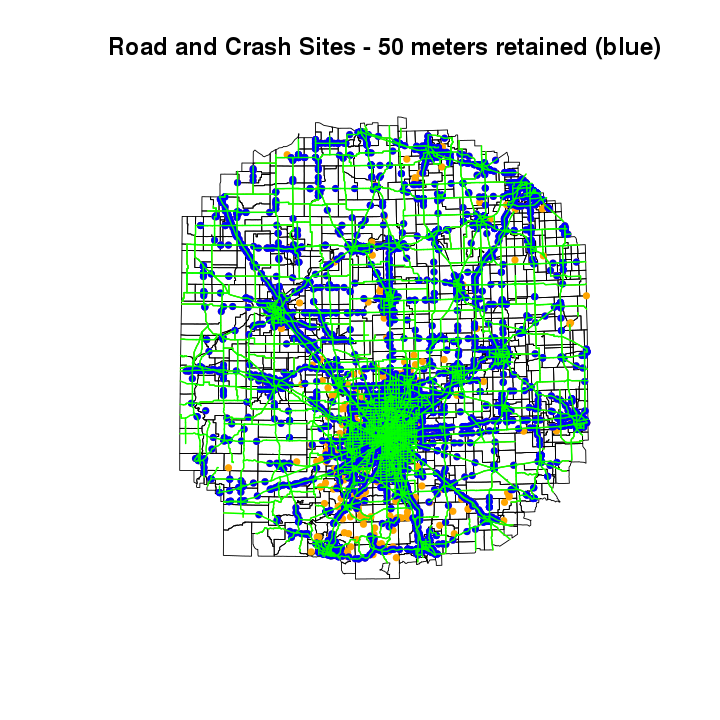

In [554]:
# only retain crashes that intersecting with the buffer

int <- overGeomGeom(roadBuffer, crashes.subset, returnList = TRUE, fn = NULL)
int <- unlist(int)
crashes.int <- crashes.subset[int, ]

plot(tranzones.subset, lwd = 0.7, main = "Road and Crash Sites - 50 meters retained (blue)")
plot(roads.subset, col = "yellow", add = TRUE)
plot(crashes.subset, col = "orange", add = TRUE, pch = 20)
plot(crashes.int, col = "blue", add = TRUE, pch = 20)
plot(roadBuffer, border = "green", add = TRUE)

**Task 6:** 

Aggregate the crash locations within 50m of a road to the appropriate road segment such as to determine the number of crashes per road segment.  

Compute the number of crashes per mile in a new column named "crash.frq" in the road dataset. Create a map to visualize the crashes per mile.  

Be sure to add a proper map title, scalebar, etc.

In [555]:
# 1 miles = 1609 meters

In [556]:
nrow(roadBuffer@data)

[1] 11977

In [557]:
nrow(crashes.int@data)

[1] 11376

In [558]:
# i need to link up the crashes with roads. 
# then i need to aggregate the number of crashes to each road (sum)
# finally, i need to output the aggregations. 


crashes.int@data$NumCrash <- 1
head(crashes.int@data)

,COUNTYCDE,TOWNSHIPCD,CITYCDE,COLLDTE,COLLDAYWEE,COLLTIMETX,COLLTIMEAM,COLLTIMEMI,MOTORVEHIN,INJUREDNMB,⋯,RDWYJUNCTI,RDWYCHARCD,SURFACETYP,PRIMARYFAC,DAMAGEESTI,MANNERCOLL,lat,LENGTHMETER,crash.id,NumCrash
4436,97,80144,36000,20131222,1,0645,A,0645,1,1,⋯,1,1,2,16,4,6,39.74148,0,2345,1
4475,97,80144,36000,20131210,3,1126,A,1126,2,0,⋯,1,1,2,44,3,12,39.73328,0,2381,1
4486,97,80144,36000,20131206,6,0604,A,0604,1,0,⋯,1,1,2,28,5,6,39.73747,0,2390,1
4497,97,80144,36000,20131226,5,0228,P,1428,2,0,⋯,1,1,2,29,3,4,39.74148,0,2399,1
4540,97,25504,36000,20131223,2,0815,A,0815,3,0,⋯,1,1,1,29,4,4,39.73328,0,2440,1
4551,97,80144,36000,20131210,3,0745,A,0745,2,2,⋯,1,1,2,13,4,1,39.73187,0,2451,1


In [559]:
linked <- over(crashes.int, roadBuffer)

In [560]:
nrow(linked)

[1] 11376

In [561]:
head(linked)

,YEAR_RECOR,STATE_CODE,BEG_POINT,END_POINT,F_SYSTEM,URBAN_CODE,FACILITY_T,THROUGH_LA,AADT,VOLUME_GRO,⋯,FAULTING,CRACK_PCT,CRACK_LEN,RouteID,FrMeasure,ToMeasure,SideOfRoad,Length,LENGTHMETER,road.id
4436,2012,18,15.59,16.57,1,41212,2,6,105514,9,⋯,0.1,0,74.453,43,57313.5,62575,L,5261.48,1603.097,2
4475,2012,18,15.59,16.57,1,41212,2,6,105514,9,⋯,0.1,0,74.453,43,57313.5,62575,L,5261.48,1603.097,2
4486,2012,18,15.59,16.57,1,41212,2,6,105514,9,⋯,0.1,0,74.453,43,57313.5,62575,L,5261.48,1603.097,2
4497,2012,18,15.59,16.57,1,41212,2,6,105514,9,⋯,0.1,0,74.453,43,57313.5,62575,L,5261.48,1603.097,2
4540,2012,18,15.59,16.57,1,41212,2,6,105514,9,⋯,0.1,0,74.453,43,57313.5,62575,L,5261.48,1603.097,2
4551,2012,18,15.59,16.57,1,41212,2,6,105514,9,⋯,0.1,0,74.453,43,57313.5,62575,L,5261.48,1603.097,2


In [562]:
crashes.int@data$RoadTrackId <- linked$road.id
head(crashes.int@data)

,COUNTYCDE,TOWNSHIPCD,CITYCDE,COLLDTE,COLLDAYWEE,COLLTIMETX,COLLTIMEAM,COLLTIMEMI,MOTORVEHIN,INJUREDNMB,⋯,RDWYCHARCD,SURFACETYP,PRIMARYFAC,DAMAGEESTI,MANNERCOLL,lat,LENGTHMETER,crash.id,NumCrash,RoadTrackId
4436,97,80144,36000,20131222,1,0645,A,0645,1,1,⋯,1,2,16,4,6,39.74148,0,2345,1,2
4475,97,80144,36000,20131210,3,1126,A,1126,2,0,⋯,1,2,44,3,12,39.73328,0,2381,1,2
4486,97,80144,36000,20131206,6,0604,A,0604,1,0,⋯,1,2,28,5,6,39.73747,0,2390,1,2
4497,97,80144,36000,20131226,5,0228,P,1428,2,0,⋯,1,2,29,3,4,39.74148,0,2399,1,2
4540,97,25504,36000,20131223,2,0815,A,0815,3,0,⋯,1,1,29,4,4,39.73328,0,2440,1,2
4551,97,80144,36000,20131210,3,0745,A,0745,2,2,⋯,1,2,13,4,1,39.73187,0,2451,1,2


In [563]:
retained <- c("crash.id", "NumCrash", "RoadTrackId")
events <- crashes.int@data[retained]

head(events)

events[] <- lapply(events, function(x) type.convert(as.character(x)))

,crash.id,NumCrash,RoadTrackId
4436,2345,1,2
4475,2381,1,2
4486,2390,1,2
4497,2399,1,2
4540,2440,1,2
4551,2451,1,2


In [564]:
agg <- aggregate(events, by = list(events$RoadTrackId), FUN = sum)
head(agg)

Group.1,crash.id,NumCrash,RoadTrackId
2,24210,10,20
5,6912,4,20
6,12308,2,12
8,117,2,16
9,12025,7,63
11,5056,1,11


In [565]:
roads.linked <- merge(roadBuffer@data, agg, by.x = "road.id", by.y = "Group.1", all = TRUE)
roads.linked.ordered <- roads.linked[order(roads.linked$road.id), ]
roads.linked.ordered$LENGTHMILE <- (as.numeric(roads.linked.ordered$LENGTHMETER)/1609) # 1609 meters in 1 mile
roads.linked.ordered$crash.frq <- as.numeric(roads.linked.ordered$NumCrash) / roads.linked.ordered$LENGTHMILE 
roads.linked.ordered$crash.frq[is.na(roads.linked.ordered$crash.frq)] <- 0
head(roads.linked.ordered)

road.id,YEAR_RECOR,STATE_CODE,BEG_POINT,END_POINT,F_SYSTEM,URBAN_CODE,FACILITY_T,THROUGH_LA,AADT,⋯,FrMeasure,ToMeasure,SideOfRoad,Length,LENGTHMETER,crash.id,NumCrash,RoadTrackId,LENGTHMILE,crash.frq
1,2012,18,11.311,12.570,5,99999,2,4,6534,⋯,8781.3,15450.8,L,6669.48945,2032.122,NA,NA,NA,1.262972140,0.000000
2,2012,18,15.590,16.570,1,41212,2,6,105514,⋯,57313.5,62575.0,L,5261.47960,1603.097,24210,10,20,0.996330996,10.036825
3,2012,18,3.020,4.000,4,99999,2,2,3584,⋯,0.0,5174.5,R,5174.49719,1576.566,NA,NA,NA,0.979842093,0.000000
4,2012,18,6.187,6.425,1,99999,2,4,47444,⋯,103976.6,105234.0,R,1257.37911,383.1085,NA,NA,NA,0.238103494,0.000000
5,2012,18,2.600,2.610,1,99999,2,4,30266,⋯,48422.2,48474.8,R,52.51993,16.02642,6912,4,20,0.009960485,401.586860
6,2012,18,0.000,8.650,4,99999,2,2,2404,⋯,0.0,2557.2,R,2557.22233,779.1458,12308,2,12,0.484242254,4.130164


In [566]:
roadBuffer@data$NumCrash <- roads.linked.ordered$NumCrash
roadBuffer@data$LENGTHMILE <-  roads.linked.ordered$LENGTHMILE
roadBuffer@data$crash.frq <- roads.linked.ordered$crash.frq

In [567]:
head(roadBuffer@data)

,YEAR_RECOR,STATE_CODE,BEG_POINT,END_POINT,F_SYSTEM,URBAN_CODE,FACILITY_T,THROUGH_LA,AADT,VOLUME_GRO,⋯,RouteID,FrMeasure,ToMeasure,SideOfRoad,Length,LENGTHMETER,road.id,NumCrash,LENGTHMILE,crash.frq
0,2012,18,11.311,12.570,5,99999,2,4,6534,4,⋯,401,8781.3,15450.8,L,6669.48945,2032.122,1,NA,1.262972140,0.000000
2,2012,18,15.590,16.570,1,41212,2,6,105514,9,⋯,43,57313.5,62575.0,L,5261.47960,1603.097,2,10,0.996330996,10.036825
3,2012,18,3.020,4.000,4,99999,2,2,3584,3,⋯,46087,0.0,5174.5,R,5174.49719,1576.566,3,NA,0.979842093,0.000000
5,2012,18,6.187,6.425,1,99999,2,4,47444,7,⋯,9,103976.6,105234.0,R,1257.37911,383.1085,4,NA,0.238103494,0.000000
7,2012,18,2.600,2.610,1,99999,2,4,30266,6,⋯,17,48422.2,48474.8,R,52.51993,16.02642,5,4,0.009960485,401.586860
8,2012,18,0.000,8.650,4,99999,2,2,2404,3,⋯,39213,0.0,2557.2,R,2557.22233,779.1458,6,2,0.484242254,4.130164


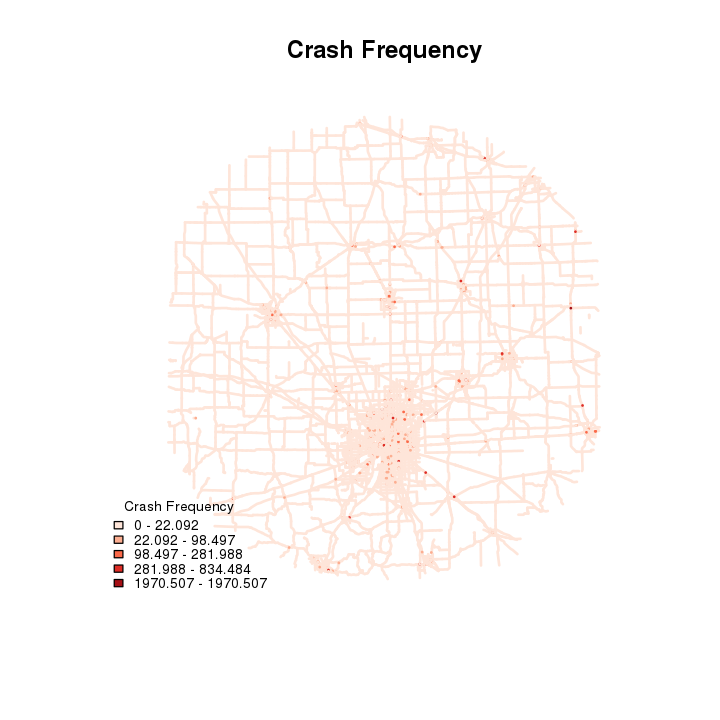

In [568]:
numcat <- 5
cate <- classIntervals(roadBuffer@data$crash.frq, numcat, style = "kmeans")

pal <- brewer.pal(numcat, "Reds")
cols <- findColours(cate, pal)

plot(roadBuffer, border = cols, lwd = 2, main = "Crash Frequency")
brks <- round(cate$brks, 3)
leg.text <- paste(brks[-numcat], brks[-1], sep = " - ")
legend("bottomleft", fill = attr(cols, "palette"), legend = leg.text, bty = "n", title = "Crash Frequency", cex = 0.7)

**Task 7:** 

Generate 3 polygon analysis areas covering the state of Indiana.  

Develop code that can iteratively create grids covering the extent of the crash data at 3 different spatial resolutions. 

For example, if using just a subset of the roads and crashes for a smaller portion of the state, initialize the routine to start with a 2km cell size, increasing the cell size at 1 km intervals over each iteration (3 iterations i.e. 2km, 3km, 4km). 

Of course, if you are analyzing the entire state, then you'll want to use much larger cell sizes (i.e. starting at 20km). 

Convert each of the grids into spatial polygon dataframes and make sure each polygon has an unique id.  

Report the number of polygons in each of the resulting analysis topologies. 3 polygon spatial dataframes should be generated in this task.

In [569]:
minlon <- min(coordinates(crashes.int)[, 1])
maxlon <- max(coordinates(crashes.int)[, 1])
minlat <- min(coordinates(crashes.int)[, 2])
maxlat <- max(coordinates(crashes.int)[, 2])

long.range <- as.numeric(c(minlon, maxlon))
lat.range <- as.numeric(c(minlat, maxlat))

In [570]:
cellsizes <- c(3000, 7000, 10000)
results <- list()

i <- 1

for (c in cellsizes){
    grd <- expand.grid(x = seq(
                                from = long.range[1],
                                to = long.range[2],
                                by = c
                                ),
                      y = seq(
                                from = lat.range[1],
                                to = lat.range[2],
                                by = c
                      ))
    
    coordinates(grd) <- ~x + y
    gridded(grd) <- TRUE
    proj4string(grd) <- proj4string(crashes.int)       
    poly <- as.SpatialPolygons.GridTopology(grd@grid, proj4string = grd@proj4string)
    
    dLen <- length(poly@polygons)
    df.dim <- matrix(nrow = dLen, ncol = 1)
    df <- data.frame(id = df.dim)
    df$id <- c(1:dLen)
    rownames(df) <- sapply(slot(poly, "polygons"), function(x) slot(x, "ID"))
    poly <- SpatialPolygonsDataFrame(Sr = poly, data = df, match.ID = TRUE)    
    
    rownames(poly@data) <- c(1:dLen)
        
    for (j in 1:dLen){
        poly@polygons[[j]]@ID <- as.character(j - 1)
    }
    
    statement <- paste("Crash Grid #", i, "has", length(poly), "polygons")
    
    print(statement)
    results[[i]] <- poly
    
    i <- i + 1
}

[1] "Crash Grid # 1 has 6314 polygons"
[1] "Crash Grid # 2 has 1155 polygons"
[1] "Crash Grid # 3 has 575 polygons"


In [571]:
poly1Grid <- results[[1]]
poly2Grid <- results[[2]]
poly3Grid <- results[[3]]

**Task 8:** Develop code that iterates over the set of 3 analysis areas generated in the previous task and maps them side-by-side (i.e. all in one row).

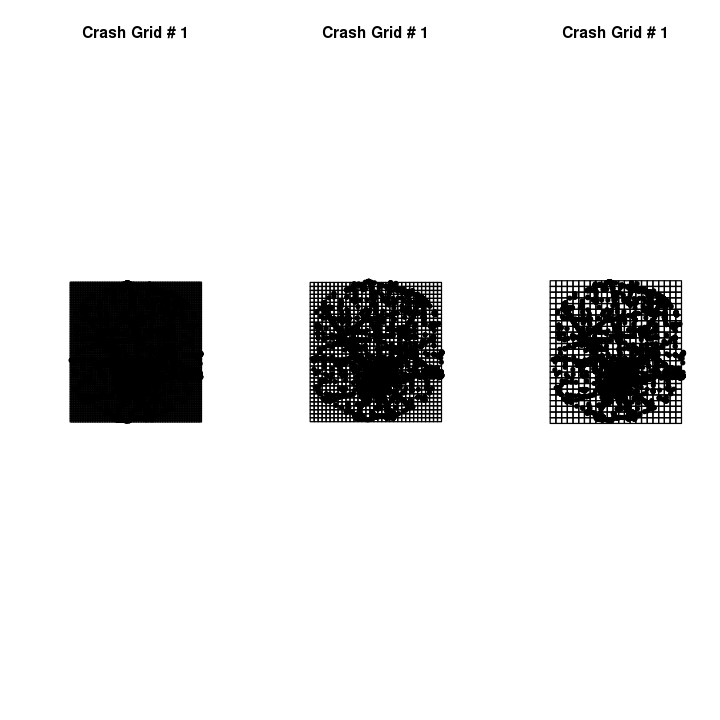

In [572]:
par(mfrow = c(1,3))

i <- 1

for (r in results){
    title <- paste("Crash Grid #", i)
    
    plot(r, main = title)
    plot(crashes.int, add = TRUE, pch = 20)
}

**Task 9:** Develop code that iterates over the 3 analysis polygon topologies and computes the number of crashes within each analysis polygon stored in a new column named "crash.frq". 

In [573]:
res <- list()

i <- 1

for (poly in results){
    c <- crashes.int 
    linked <- over(c, poly)
    c@data$polyId <- linked$id
    retained <- c("NumCrash", "polyId")
    events <- c@data[retained]
    events[] <- lapply(events, function(x) type.convert(as.character(x)))
        
    agg <- aggregate(events, by = list(events$polyId), FUN = sum)
    poly.linked <- merge(poly@data, agg, by.x = "id", by.y = "Group.1", all = TRUE)
    poly.linked.ordered <- poly.linked[order(poly.linked$id), ]
    poly@data$crash.frq <- poly.linked.ordered$NumCrash
    poly@data$crash.frq[is.na(poly@data$crash.frq)] <- 0
    
    res[[i]] <- poly
    i <- i + 1    
}

In [574]:
poly1Crash <- res[[1]]
poly2Crash <- res[[2]]
poly3Crash <- res[[3]]

In [575]:
head(poly1Crash@data, 25)

id,crash.frq
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0
10,0


In [576]:
head(poly2Crash@data, 25)

id,crash.frq
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0
10,0


In [577]:
head(poly3Crash@data, 25)

id,crash.frq
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,11
9,10
10,8


**Task 10:** Develop code to iterate over the analysis polygons and map the new crash frequency variable "crash.frq". 

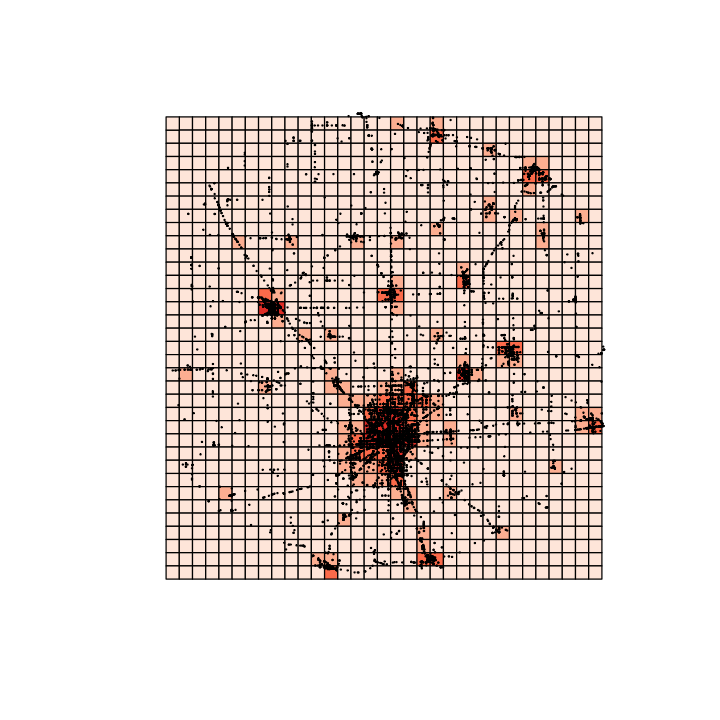

In [578]:
# JACKY : This is just a sanity-check to make sure my colors match up with my points

numcat <- 5
cate <- classIntervals(poly2Crash@data$crash.frq, numcat, style = "kmeans")

pal <- brewer.pal(numcat, "Reds")
cols <- findColours(cate, pal)
plot(poly2Crash, col = cols)
plot(crashes.int, lwd = 0.5,  cex = 0.3, add = TRUE, pch = 20)

In [579]:
# JACKY: Nice! It looks great! Time to loop them.

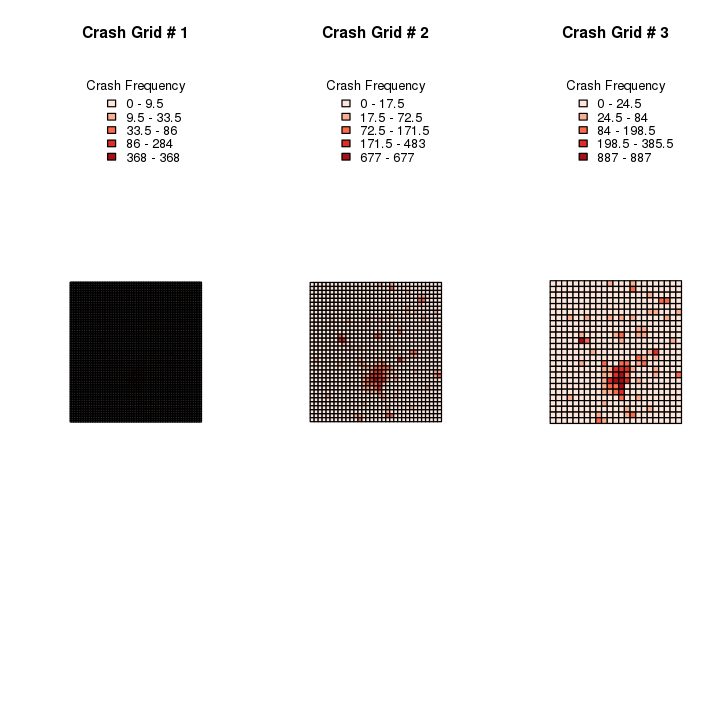

In [580]:
par(mfrow = c(1,3))
i <- 1

for (p in res){
    numcat <- 5
    cate <- classIntervals(p@data$crash.frq, numcat, style = "kmeans")
    title <- paste("Crash Grid #", i)
    
    pal <- brewer.pal(numcat, "Reds")
    cols <- findColours(cate, pal)
    plot(p, col = cols,  main = title)   
    
    brks <- round(cate$brks, 3)
    leg.text <- paste(brks[-numcat], brks[-1], sep = " - ")
    legend("top", fill = attr(cols, "palette"), legend = leg.text, bty = "n", title = "Crash Frequency")
    
    i <- i + 1
}

**Task 11:** Compute the total miles of road features within each analysis area and store the total length in a new column in the polygons datasets.

In [581]:
res2 <- list()

i <- 1

for (poly in res){
    r <- roadBuffer
    linked <- over(r, poly)
    r@data$polyId <- linked$id
    retained <- c("road.id", "LENGTHMILE", "polyId")
    events <- r@data[retained]
    events[] <- lapply(events, function(x) type.convert(as.character(x)))
    agg <- aggregate(events, by = list(events$polyId), FUN = sum)
    poly.linked <- merge(poly@data, agg, by.x = "id", by.y = "Group.1", all = TRUE)
    poly@data$total.miles <- poly.linked$LENGTHMILE
    poly@data$total.miles[is.na(poly@data$total.miles)] <- 0
    
    res2[[i]] <- poly
        
    i <- i + 1
}

In [582]:
length(res2)

[1] 3

In [583]:
poly1Road <- res2[[1]]
poly2Road <- res2[[2]]
poly3Road <- res2[[3]]

In [584]:
head(poly1Road@data, 15)

id,crash.frq,total.miles
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0
10,0,0


In [585]:
head(poly2Road@data, 15)

id,crash.frq,total.miles
1,0,0.000000
2,0,0.000000
3,0,0.000000
4,0,0.000000
5,0,0.000000
6,0,0.000000
7,0,0.000000
8,0,0.000000
9,0,0.000000
10,0,5.347769


In [586]:
head(poly3Road@data, 15)

id,crash.frq,total.miles
1,0,0.000000
2,0,0.000000
3,0,0.000000
4,0,0.000000
5,0,0.000000
6,0,0.000000
7,0,5.347769
8,11,4.997900
9,10,11.528288
10,8,18.372024


**Task 12:** Iterate through analysis polygons and visualize the total length of roads in each analysis polygon. Be sure to add a proper map title, scalebar, etc.

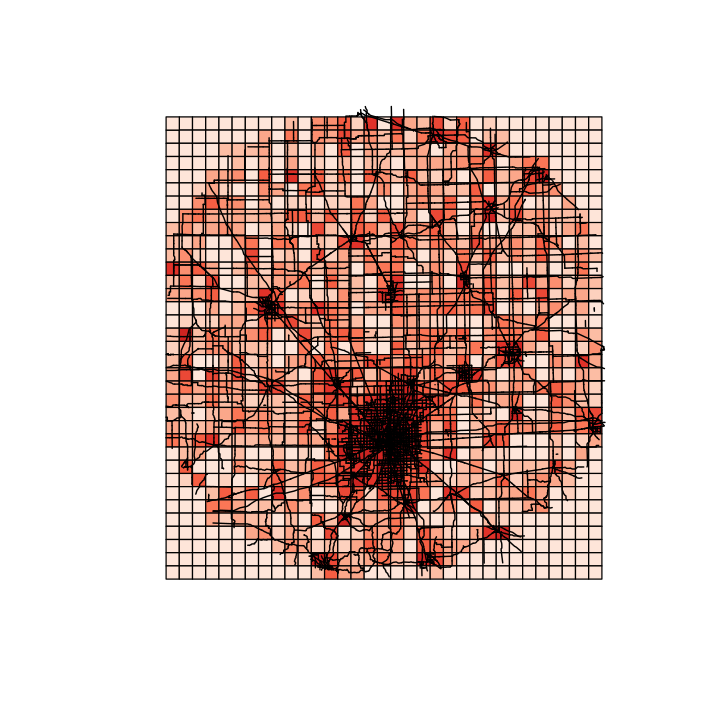

In [587]:
# JACKY: Quick sanity-check

numcat <- 5
cate <- classIntervals(poly2Road@data$total.miles, style = "kmeans")
pal <- brewer.pal(numcat, "Reds")
cols <- findColours(cate, pal)

plot(poly2Road, col = cols)
plot(roadBuffer, add = TRUE)

In [588]:
# JACKY: Looks good!

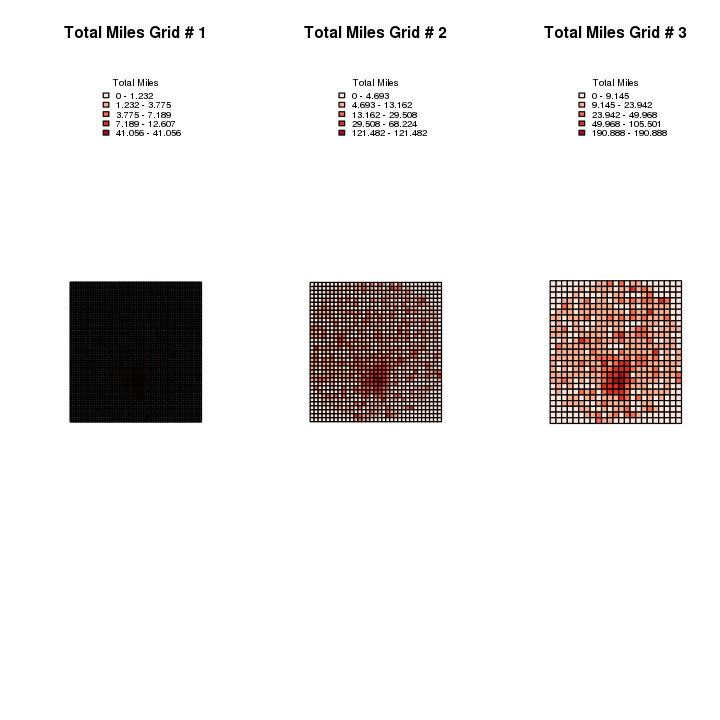

In [589]:
par(mfrow = c(1,3))

i <- 1
for (p in res2){
    numcat <- 5
    cate <- classIntervals(p@data$total.miles, numcat, style = "kmeans")
    pal <- brewer.pal(numcat, "Reds")
    cols <- findColours(cate, pal)
    
    title <- paste("Total Miles Grid #", i)
    
    plot(p, col = cols, main = title)   
    brks <- round(cate$brks, 3)
    leg.text <- paste(brks[-numcat], brks[-1], sep = " - ")
    legend("top", fill = attr(cols, "palette"), legend = leg.text, bty = "n", title = "Total Miles", cex = 0.7)
    
    i <- i + 1
}

# Task SET B - ANALYSIS

As described earlier, this section can be formatted in a range of ways depending on how you decide to approach the problem. Feel free to use as many codeblocks as you wish.

**Task 13:** Dataset 1 Analysis

In [590]:
# analyze total miles and crash frequency of the 3 polygons. 
# explore the effect of MAUP.

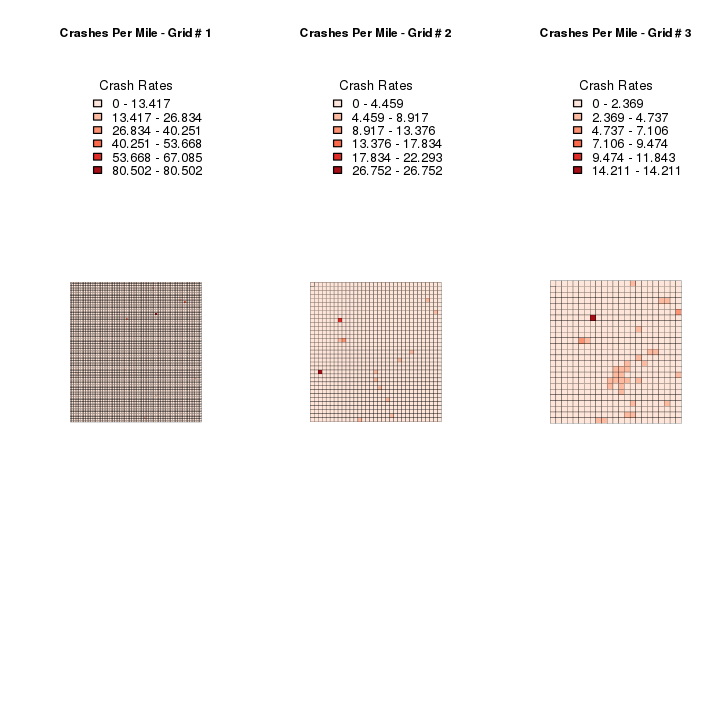

In [591]:
polys <- list(poly1Road, poly2Road, poly3Road)
results <- list()

i <- 1

par(mfrow=c(1,3))

for (p in polys){
    crashFreq <- p@data$crash.frq
    roadLength <- p@data$total.miles
    crashRate <- crashFreq/roadLength
    crashRate[is.na(crashRate)] <- 0
    crashRate[!is.finite(crashRate)] <- 0
    p@data$crashRate <- crashRate
    
    numcat <- 6
    cate <- classIntervals(crashRate, numcat, style = "equal")

    pal <- brewer.pal(numcat, "Reds")
    cols <- findColours(cate, pal)
    plot(p, col = cols, lwd = 0.2, main = paste("Crashes Per Mile - Grid #", i), cex.main = 0.9)

    brks.dec <- round(cate$brks, 3)
    leg.text <- paste(brks.dec[-numcat], brks.dec[-1], sep = " - ")
    legend("top", fill = attr(cols, "palette"), legend = leg.text, bty = "n", title = "Crash Rates")
    
    results[[i]] <- p
    
    i <- i + 1
}

In [592]:
# Get the neighbors

p.nb_list <- list()
p.nb.self_list <- list()
p.listb_list <- list()
p.listw_list <- list()
p.listb.self_list <- list()
p.listw.self_list <- list()

i <- 1

for (p in results){
    p.nb <- poly2nb(p, queen = TRUE)
    p <- p[card(p.nb) >= 1, ]
    
    p.nb <- poly2nb(p, queen = TRUE)
    p.nb_list[[i]] <- p.nb
    
    p.nb.self <- include.self(p.nb)
    p.nb.self_list[[i]] <- p.nb.self

    # neighborhood list
    p.listb <- nb2listw(p.nb, style = "B")
    p.listb_list[[i]] <- p.listb
        
    p.listw <- nb2listw(p.nb, style = "W")
    p.listw_list[[i]] <- p.listw    
    
    p.listb.self <- nb2listw(p.nb.self, style = "B")
    p.listb.self_list[[i]] <- p.listb.self    
    
    p.listw.self <- nb2listw(p.nb.self, style = "W")
    p.listw.self_list[[i]] <- p.listw.self
    
    i <- i + 1
}

In [593]:
# run autocorrelation tests
polys <- results

for (i in 1:length(polys)){
    
    crashRate <- polys[[i]]@data$crashRate
    listb <- p.listb_list[[i]]
    
    mt <- moran.test(crashRate, listb)
    print(paste("Poly", i, "Results:"))
    print(mt)
    print("===========================================================")
}

[1] "Poly 1 Results:"

	Moran I test under randomisation

data:  crashRate  
weights: listb  

Moran I statistic standard deviate = 24.988, p-value < 2.2e-16
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
     0.1492704490     -0.0001584033      0.0000357609 

[1] "==========================================================="
[1] "Poly 2 Results:"

	Moran I test under randomisation

data:  crashRate  
weights: listb  

Moran I statistic standard deviate = 11.904, p-value < 2.2e-16
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
     0.1647633261     -0.0008665511      0.0001935911 

[1] "==========================================================="
[1] "Poly 3 Results:"

	Moran I test under randomisation

data:  crashRate  
weights: listb  

Moran I statistic standard deviate = 11.411, p-value < 2.2e-16
alternative hypothesis: greater
sample estimates:
Moran I statistic     

<div style="color: red;">**HYPOTHESES**</div>

* H0 = Data is randomly distributed. No autocorrelation. 
* H1 = Data is not randomly distributed. Signs of autocorrelation. 

<div style="color: red;">**RESULTS**</div>

* In all 3 cases, the p-values were below the alpha value of 0.05. 
* In all 3 cases, we'd reject the null hypothesis that the data is distributed randomly. There are signs of autocorrelation. 

In [594]:
# compute the Gi statistic

gi_list <- list()
AzcG_list <- list()

for (i in 1:length(polys)){
    
    varA <- polys[[i]]@data$crashRate
    
    nb <- p.nb_list[[i]]
    nb.self <- p.nb.self_list[[i]]
    listb <- p.listb_list[[i]]
    listw <- p.listw_list[[i]]
    listb.self <- p.listb.self_list[[i]]
    listw.self <- p.listw.self_list[[i]] 
        
    gi <- localG(varA, listb.self)
    gi_list[[i]] <- gi
    
    feat.d.sar <- errorsarlm(varA ~1, listw = listw)
    rho <- feat.d.sar$lambda
    rho2 <- unname(rho)
    
    dvalues <- length(varA)
    
    ESS <- dvalues * (1-(1/(1-exp(-1.92349)))*((dvalues-1)/dvalues)*(1-exp((-2.12373*rho2)+ (.20024*sqrt(rho2)))))
    print(paste("ESS = ", ESS))
    
    zAdjusted <- list()
    probsU <- c(0.90, 0.95)
    
    j <- 1
    
    for (pr in probsU){
        rmean <- mean(varA)
        newpr <- 1 - (((1 - pr)/ESS)/2)
        
        errorN <- qnorm(newpr, mean = rmean, lower.tail = TRUE)
        zAdjusted[[j]] <- 0 + errorN
        
        j <- j + 1
    }
    
    AzcG <- unlist(zAdjusted)
    AzcG_list[[i]] <- AzcG
    print(paste(probsU, AzcG, sep = " | "))    
    print("=======================================================")
    
    
}

[1] "ESS =  2593.26178994099"
[1] "0.9 | 4.46630788054363"  "0.95 | 4.62343529666151"
[1] "======================================================="
[1] "ESS =  441.265278575741"
[1] "0.9 | 4.22176380511524"  "0.95 | 4.39460058603601"
[1] "======================================================="
[1] "ESS =  157.872830264469"
[1] "0.9 | 3.98324103198132"  "0.95 | 4.16759021736898"
[1] "======================================================="


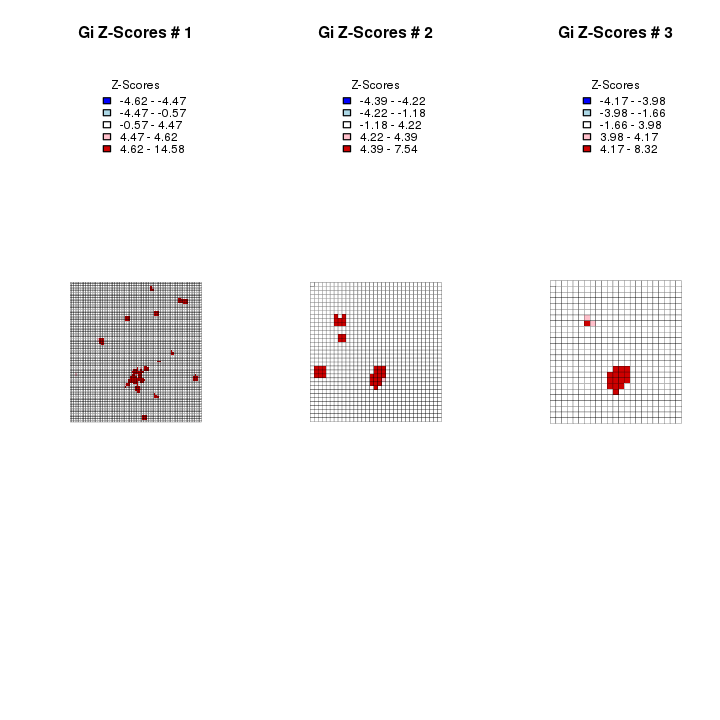

In [595]:
# let's visualize the differences of the Gi values in the different areas. 

par(mfrow=c(1,3))
i <- 1

for (p in polys){
    gi <- gi_list[[i]]
    AzcG <- AzcG_list[[i]]
    
    n1 <- 4 + length(AzcG) - 1
    n2 <- 4 + length(AzcG)
    
    z.Gi <- classIntervals(gi, n = n1, style = "fixed", fixedBreaks = c(min(gi), -AzcG, AzcG, max(gi)))
    pal <- c("blue", "lightblue", "white", "pink", "red3")
    cols.Gi <- findColours(z.Gi, pal)
    
    plot(p, col = cols.Gi, lwd = 0.2, main = paste("Gi Z-Scores #", i))
    
    brks <- round(z.Gi$brks, 2)
    leg <- paste(brks[-n2], brks[-1], sep = " - ")
    legend("top", fill = pal, legend = leg, bty = "n", title = "Z-Scores", cex = 0.9)    
    
    i <- i + 1
}



**Task 14:** Dataset 2 Analysis

<div style="color:red">** JACKY **: I will try to use the crash data to predict irrigation in farming</div>

In [596]:
ag <- readOGR("/dsa/data/geospatial/DS8612/usagriculture","usfarming")

OGR data source with driver: ESRI Shapefile 
Source: "/dsa/data/geospatial/DS8612/usagriculture", layer: "usfarming"
with 3070 features
It has 93 fields


In [597]:
head(ag@data, 3)

,Join_Count,TARGET_FID,atlas_stco,atlas_name,atlas_caps,atlas_area,atlas_acre,entity,cntya,cntyn,⋯,y12_M264_v,y12_M264_c,y12_M264_1,y12_M265_v,y12_M265_c,y12_M265_1,y12_M266_v,y12_M266_c,y12_M266_1,coastal
0,1,0,01001,Autauga,AUTAUGA,594.437,380439.7,County,001,1,⋯,2.37,Sparse Data,2.37,0.09,Less than 1,0.09,2.96,1 - 2,2.96,NA
1,2,1,01003,Baldwin,BALDWIN,1589.840,1017497.6,County,003,3,⋯,0.63,Sparse Data,0.63,0.04,Less than 1,0.04,4.09,3 - 5,4.09,1
2,2,2,01005,Barbour,BARBOUR,884.876,566320.6,County,005,5,⋯,0.03,Sparse Data,0.03,0.00,Less than 1,0.00,7.68,6 - 8,7.68,NA


In [598]:
# ag is for the whole USA. Need to subset it to Indiana only

ag@data$stcode <- substr(ag@data$atlas_stco, start = 1, stop = 2)
head(ag@data$stcode)

[1] "01" "01" "01" "01" "01" "01"

In [599]:
ag_in <- ag[grep("18", ag@data$stcode), ]
paste(length(ag_in), "polygons for Indiana")

[1] "92 polygons for Indiana"

In [600]:
# Sync up the CRS

newCRS <- CRS("+init=epsg:32616 +proj=utm +zone=16 +datum=WGS84 +units=m +no_defs +ellps=WGS84 +towgs84=0,0,0")

ag <- spTransform(ag, newCRS)
crash <- spTransform(crashes, newCRS)
ag_in <- spTransform(ag_in, newCRS)

print(proj4string(ag))
print(proj4string(crash))
print(proj4string(ag_in))

[1] "+init=epsg:32616 +proj=utm +zone=16 +datum=WGS84 +units=m +no_defs +ellps=WGS84 +towgs84=0,0,0"
[1] "+init=epsg:32616 +proj=utm +zone=16 +datum=WGS84 +units=m +no_defs +ellps=WGS84 +towgs84=0,0,0"
[1] "+init=epsg:32616 +proj=utm +zone=16 +datum=WGS84 +units=m +no_defs +ellps=WGS84 +towgs84=0,0,0"


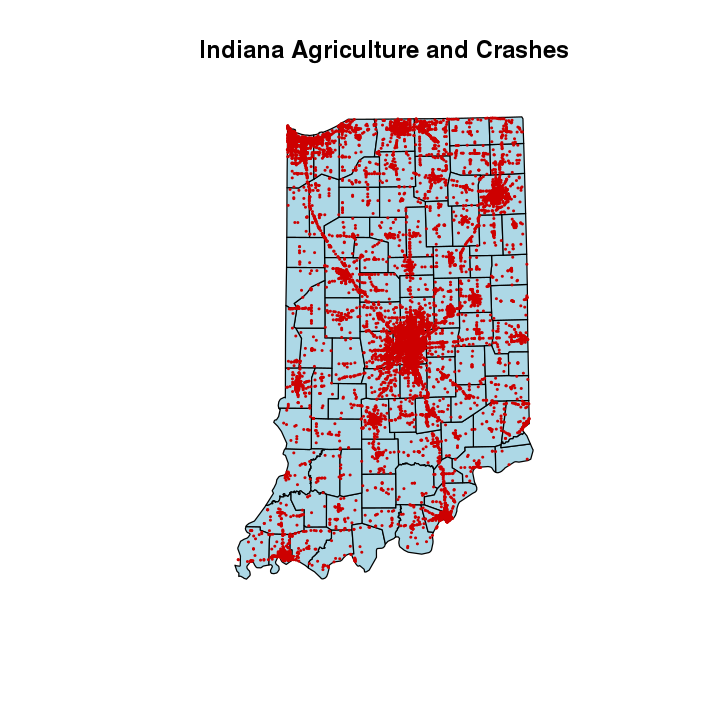

In [601]:
plot(ag_in, col = "lightblue", main = "Indiana Agriculture and Crashes")
plot(crash, pch = 20, cex = 0.3, col = "red3", add = TRUE)

In [602]:
crash@data$NumCrash <- 1
head(crash@data)

COUNTYCDE,TOWNSHIPCD,CITYCDE,COLLDTE,COLLDAYWEE,COLLTIMETX,COLLTIMEAM,COLLTIMEMI,MOTORVEHIN,INJUREDNMB,⋯,SURFACECON,MEDIANTYPE,RDWYJUNCTI,RDWYCHARCD,SURFACETYP,PRIMARYFAC,DAMAGEESTI,MANNERCOLL,lat,NumCrash
1,65862,17074,20131208,1,0753,P,1953,1,0,⋯,5,3,1,1,2,56,3,6,40.84790,1
135,83942,84752,20131218,4,1130,A,1130,2,0,⋯,1,4,1,1,1,25,3,12,40.16505,1
29,80540,2782,20131203,3,0628,P,1828,1,0,⋯,1,4,1,1,1,64,5,7,39.02977,1
29,44604,82790,20131214,7,1013,P,2213,1,0,⋯,2,4,1,1,1,64,5,2,39.29162,1
151,68454,1666,20131205,5,0620,A,0620,1,0,⋯,2,4,1,1,1,64,3,7,41.63125,1
33,28836,81278,20131207,7,1100,P,2300,2,0,⋯,1,4,1,1,1,14,3,11,41.46279,1


In [603]:
# I want to put crash data into the ag data

# set uniqueIDs
ag_in@data$agID <- seq.int(nrow(ag_in@data))

linked <- over(crash, ag_in)
head(linked)

Join_Count,TARGET_FID,atlas_stco,atlas_name,atlas_caps,atlas_area,atlas_acre,entity,cntya,cntyn,⋯,y12_M264_1,y12_M265_v,y12_M265_c,y12_M265_1,y12_M266_v,y12_M266_c,y12_M266_1,coastal,stcode,agID
1,662,18001,Adams,ADAMS,339.028,216977.9,County,001,1,⋯,2.50,(D),Less than 1,0.00,1.21,1 - 2,1.21,NA,18,1
2,729,18135,Randolph,RANDOLPH,452.379,289522.6,County,135,135,⋯,0.40,0.00,Less than 1,0.00,1.09,1 - 2,1.09,NA,18,68
1,676,18029,Dearborn,DEARBORN,305.034,195221.8,County,029,29,⋯,-5.69,0.11,Less than 1,0.11,0.45,Less than 1,0.45,NA,18,15
1,676,18029,Dearborn,DEARBORN,305.034,195221.8,County,029,29,⋯,-5.69,0.11,Less than 1,0.11,0.45,Less than 1,0.45,NA,18,15
1,737,18151,Steuben,STEUBEN,308.742,197594.9,County,151,151,⋯,1.04,0.00,Less than 1,0.00,8.38,6 - 8,8.38,NA,18,76
1,678,18033,DeKalb,DEKALB,362.824,232207.4,County,033,33,⋯,1.61,(D),Less than 1,0.00,8.55,6 - 8,8.55,NA,18,17


In [604]:
crash@data$agtrackid <- linked$agID
head(crash@data)

COUNTYCDE,TOWNSHIPCD,CITYCDE,COLLDTE,COLLDAYWEE,COLLTIMETX,COLLTIMEAM,COLLTIMEMI,MOTORVEHIN,INJUREDNMB,⋯,MEDIANTYPE,RDWYJUNCTI,RDWYCHARCD,SURFACETYP,PRIMARYFAC,DAMAGEESTI,MANNERCOLL,lat,NumCrash,agtrackid
1,65862,17074,20131208,1,0753,P,1953,1,0,⋯,3,1,1,2,56,3,6,40.84790,1,1
135,83942,84752,20131218,4,1130,A,1130,2,0,⋯,4,1,1,1,25,3,12,40.16505,1,68
29,80540,2782,20131203,3,0628,P,1828,1,0,⋯,4,1,1,1,64,5,7,39.02977,1,15
29,44604,82790,20131214,7,1013,P,2213,1,0,⋯,4,1,1,1,64,5,2,39.29162,1,15
151,68454,1666,20131205,5,0620,A,0620,1,0,⋯,4,1,1,1,64,3,7,41.63125,1,76
33,28836,81278,20131207,7,1100,P,2300,2,0,⋯,4,1,1,1,14,3,11,41.46279,1,17


In [605]:
retained <- c("NumCrash", "agtrackid")
events <- crash@data[retained]
events[] <- lapply(events, function(x) type.convert(as.character(x)))
head(events)

NumCrash,agtrackid
1,1
1,68
1,15
1,15
1,76
1,17


In [606]:
agg <- aggregate(events, by = list(events$agtrackid), FUN = sum)
head(agg)

Group.1,NumCrash,agtrackid
1,41,41
2,820,1640
3,179,537
4,10,40
5,10,50
6,199,1194


In [607]:
ag.linked <- merge(ag_in@data, agg, by.x = "agID", by.y = "Group.1", all = TRUE)
ag.linked.ordered <- ag.linked[order(ag.linked$agID), ]
ag.linked.ordered$CrashesPerAcre <- ag.linked.ordered$NumCrash / ag.linked.ordered$atlas_acre
ag.linked.ordered$CrashesPerAcre[is.na(ag.linked.ordered$CrashesPerAcre)] <- 0

head(ag.linked.ordered)

agID,Join_Count,TARGET_FID,atlas_stco,atlas_name,atlas_caps,atlas_area,atlas_acre,entity,cntya,⋯,y12_M265_c,y12_M265_1,y12_M266_v,y12_M266_c,y12_M266_1,coastal,stcode,NumCrash,agtrackid,CrashesPerAcre
1,1,662,18001,Adams,ADAMS,339.028,216977.9,County,001,⋯,Less than 1,0,1.21,1 - 2,1.21,NA,18,41,41,1.889593e-04
2,1,663,18003,Allen,ALLEN,657.316,420682.2,County,003,⋯,Less than 1,0,2.61,1 - 2,2.61,NA,18,820,1640,1.949215e-03
3,1,664,18005,Bartholomew,BARTHOLOMEW,406.895,260412.8,County,005,⋯,Less than 1,0,1.53,1 - 2,1.53,NA,18,179,537,6.873702e-04
4,1,665,18007,Benton,BENTON,406.417,260106.9,County,007,⋯,Less than 1,0,0.66,Less than 1,0.66,NA,18,10,40,3.844573e-05
5,2,666,18009,Blackford,BLACKFORD,165.080,105651.2,County,009,⋯,Less than 1,0,0.95,Less than 1,0.95,NA,18,10,50,9.465108e-05
6,1,667,18011,Boone,BOONE,422.912,270663.7,County,011,⋯,1 - 4,0,0.33,Less than 1,0.33,NA,18,199,1194,7.352298e-04


In [608]:
ag_in@data$NumCrash <- ag.linked.ordered$NumCrash
ag_in@data$CrashesPerAcre <- ag.linked.ordered$CrashesPerAcre

In [609]:
head(ag_in@data)

,Join_Count,TARGET_FID,atlas_stco,atlas_name,atlas_caps,atlas_area,atlas_acre,entity,cntya,cntyn,⋯,y12_M265_c,y12_M265_1,y12_M266_v,y12_M266_c,y12_M266_1,coastal,stcode,agID,NumCrash,CrashesPerAcre
662,1,662,18001,Adams,ADAMS,339.028,216977.9,County,001,1,⋯,Less than 1,0,1.21,1 - 2,1.21,NA,18,1,41,1.889593e-04
663,1,663,18003,Allen,ALLEN,657.316,420682.2,County,003,3,⋯,Less than 1,0,2.61,1 - 2,2.61,NA,18,2,820,1.949215e-03
664,1,664,18005,Bartholomew,BARTHOLOMEW,406.895,260412.8,County,005,5,⋯,Less than 1,0,1.53,1 - 2,1.53,NA,18,3,179,6.873702e-04
665,1,665,18007,Benton,BENTON,406.417,260106.9,County,007,7,⋯,Less than 1,0,0.66,Less than 1,0.66,NA,18,4,10,3.844573e-05
666,2,666,18009,Blackford,BLACKFORD,165.080,105651.2,County,009,9,⋯,Less than 1,0,0.95,Less than 1,0.95,NA,18,5,10,9.465108e-05
667,1,667,18011,Boone,BOONE,422.912,270663.7,County,011,11,⋯,1 - 4,0,0.33,Less than 1,0.33,NA,18,6,199,7.352298e-04


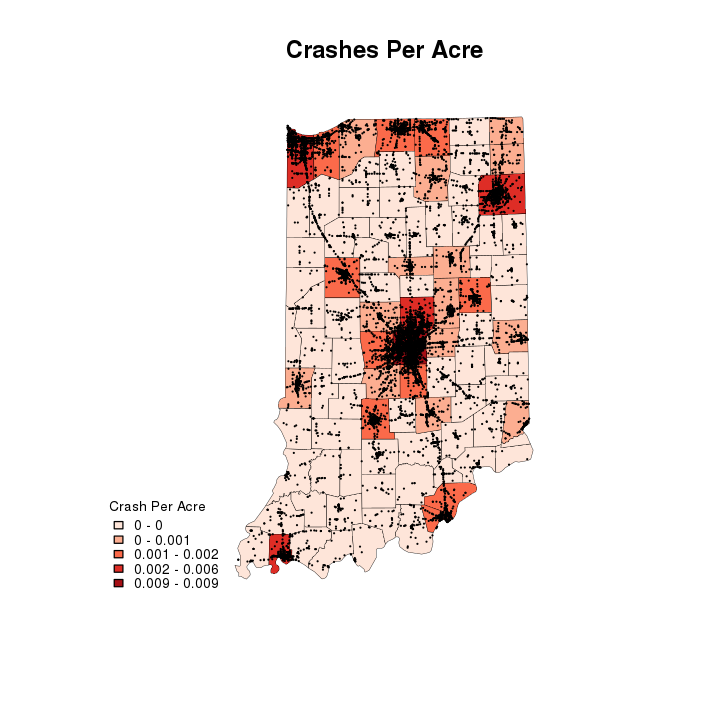

In [610]:
numcat <- 5
cate <- classIntervals(ag_in@data$CrashesPerAcre, numcat, style = "kmeans")

pal <- brewer.pal(numcat, "Reds")
cols <- findColours(cate, pal)

plot(ag_in, col = cols, lwd = 0.3, main = "Crashes Per Acre")
plot(crash, pch = 20, cex = 0.1, add = TRUE)

brks <- round(cate$brks, 3)
leg.text <- paste(brks[-numcat], brks[-1], sep = " - ")
legend("bottomleft", fill = attr(cols, "palette"), legend = leg.text, bty = "n", title = "Crash Per Acre", cex = 0.7)

In [611]:
ag_in.nb <- poly2nb(ag_in, queen = TRUE)
has.nb <- card(ag_in.nb) >= 1
ag_in <- ag_in[has.nb, ]
ag_in.nb <- poly2nb(ag_in, queen = TRUE)

ag_in.nb.listb <- nb2listw(ag_in.nb, style = "B") 
ag_in.nb.listw <- nb2listw(ag_in.nb, style = "W")

In [612]:
# response variable = y12_M247_1 
# acres of irrigated land as percent of land in farms acreage
# depedent variable

inVa <- ag_in$y12_M247_1
Y_Var <- inVa

In [613]:
# explanatory variable = CrashesPerAcre
# independent variable

Ex_Var <- ag_in$CrashesPerAcre

In [614]:
# evaluate the normality of the dependent variable

shapiro.test(Y_Var)


	Shapiro-Wilk normality test

data:  Y_Var
W = 0.83157, p-value = 7.587e-09


<div style="color: red;">**HYPOTHESES**</div>

* H0 = Data is normally distributed. 
* H1 = Data is not normally distributed.

<div style="color: red;">**RESULTS**</div>

* P-value is lower than the alpha value (0.05) therefore, the null hypothesis is rejected. 
* Data is not normally distributed. 

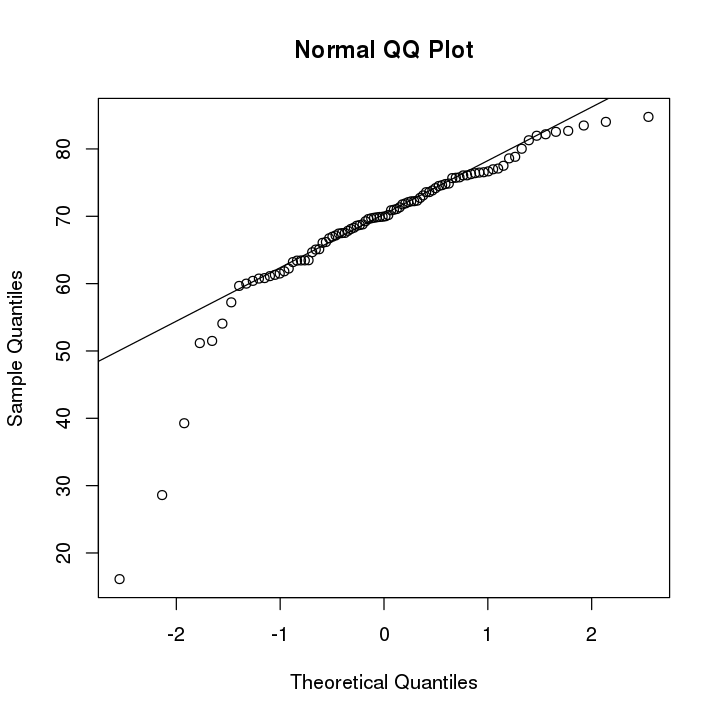

In [615]:
qqnorm(Y_Var, main = "Normal QQ Plot", plot.it = TRUE, datax = FALSE)
qqline(Y_Var, datax = FALSE)

** JACKY **:
Let's transform the Y_Var to make it more suitable for analysis!

In [616]:
lambdapwr <- (1/3)
y.Y_Var <- Y_Var^(lambdapwr)
shapiro.test(y.Y_Var)


	Shapiro-Wilk normality test

data:  y.Y_Var
W = 0.69846, p-value = 1.885e-12


<div style="color: red;">**HYPOTHESES**</div>

* H0 = Data is normally distributed. 
* H1 = Data is not normally distributed.

<div style="color: red;">**RESULTS**</div>

* P-value is lower than the alpha value (0.05) therefore, the null hypothesis is rejected. 
* Data is not normally distributed. 

**JACKY**: For the sake of this task, I'm going to continue with the analysis even though the dependent variable is not normally distributed. I will note that the data became a bit better though. 

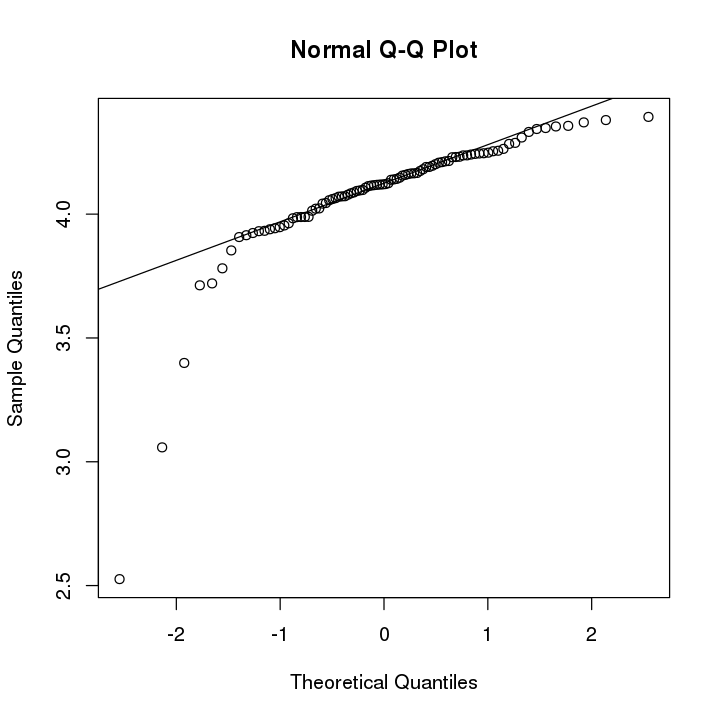

In [617]:
qqnorm(y.Y_Var, plot.it = TRUE, datax = FALSE)
qqline(y.Y_Var, datax = FALSE)

In [618]:
Y_Var.lm <- lm(y.Y_Var ~ Ex_Var)

summary(Y_Var.lm)


Call:
lm(formula = y.Y_Var ~ Ex_Var)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.55154 -0.07098  0.04125  0.13713  0.31252 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.07326    0.02973 137.026   <2e-16 ***
Ex_Var      24.89239   25.81369   0.964    0.337    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2551 on 90 degrees of freedom
Multiple R-squared:  0.01023,	Adjusted R-squared:  -0.000771 
F-statistic: 0.9299 on 1 and 90 DF,  p-value: 0.3375


**JACKY**: The explanatory variable (CrashesPerAcre) is a pretty bad predictor (obviously) for irrigation. 

In [619]:
# Let's test the residuals to determine if we can trust the OLS linear regression model.

residuals <- resid(Y_Var.lm)
shapiro.test(residuals)


	Shapiro-Wilk normality test

data:  residuals
W = 0.69916, p-value = 1.954e-12


<div style="color: red;">**HYPOTHESES**</div>

* H0 = Data is normally distributed. 
* H1 = Data is not normally distributed.

<div style="color: red;">**RESULTS**</div>

* P-value is lower than the alpha value (0.05) therefore, the null hypothesis is rejected. 
* Data is not normally distributed. 

**JACKY**: This is not surprising given that the Y_Var isn't normal. 

In [620]:
resids <- residuals(Y_Var.lm)

moran.test(resids, ag_in.nb.listb)


	Moran I test under randomisation

data:  resids  
weights: ag_in.nb.listb  

Moran I statistic standard deviate = 4.5647, p-value = 2.501e-06
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
       0.24581181       -0.01098901        0.00316501 


<div style="color: red;">**HYPOTHESES**</div>

* H0 = Data is randomly distributed. No spatial autocorrelation. 
* H1 = Data is not randomly distributed. Signs of spatial autocorrelation. 

<div style="color: red;">**RESULTS**</div>

* P-value is lower than the alpha value (0.05) therefore, the null hypothesis is rejected. 
* Data is not randomly distributed. Signs of autocorrelation may exist. 

**JACKY**: There seems to be signs of autocorrelation at work in the residuals. Looks like we cannot trust the OLS model afterall.

In [621]:
# conduct a SAR specification using transformed dependent and explanatory variable

Y_Var_Sar <- errorsarlm(y.Y_Var ~ Ex_Var, listw = ag_in.nb.listw)

summary(Y_Var_Sar)


Call:errorsarlm(formula = y.Y_Var ~ Ex_Var, listw = ag_in.nb.listw)

Residuals:
      Min        1Q    Median        3Q       Max 
-1.464920 -0.052890  0.032092  0.106408  0.282718 

Type: error 
Coefficients: (asymptotic standard errors) 
             Estimate Std. Error z value Pr(>|z|)
(Intercept)  4.081559   0.048334  84.445   <2e-16
Ex_Var       3.634708  23.752013   0.153   0.8784

Lambda: 0.48999, LR test value: 12.649, p-value: 0.00037581
Asymptotic standard error: 0.11906
    z-value: 4.1155, p-value: 3.8627e-05
Wald statistic: 16.938, p-value: 3.8627e-05

Log likelihood: 2.478164 for error model
ML residual variance (sigma squared): 0.052487, (sigma: 0.2291)
Number of observations: 92 
Number of parameters estimated: 4 
AIC: 3.0437, (AIC for lm: 13.692)


<b style="color: red;">JACKY: Lambda is positive and statistically significant.</b>

In [622]:
sar_residuals <- residuals(Y_Var_Sar)
shapiro.test(sar_residuals)


	Shapiro-Wilk normality test

data:  sar_residuals
W = 0.65859, p-value = 2.602e-13


**JACKY**: Still not normal

In [623]:
moran.test(sar_residuals, ag_in.nb.listb)


	Moran I test under randomisation

data:  sar_residuals  
weights: ag_in.nb.listb  

Moran I statistic standard deviate = 0.51139, p-value = 0.3045
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
      0.017155515      -0.010989011       0.003028919 


<div style="color: red;">**HYPOTHESES**</div>

* H0 = Residuals are randomly distributed. No spatial autocorrelation. 
* H1 = Residuals are not randomly distributed. Signs of spatial autocorrelation. 

<div style="color: red;">**RESULTS**</div>

* P-value is higher than the alpha value (0.05) therefore, the null hypothesis cannot be rejected. 
* Residuals are randomly distributed. No signs of spatial autocorrelation. 

In [624]:
# backtransform the fitted SAR values into the original measurements

backfitted <- Y_Var_Sar$fitted^(1/lambdapwr)

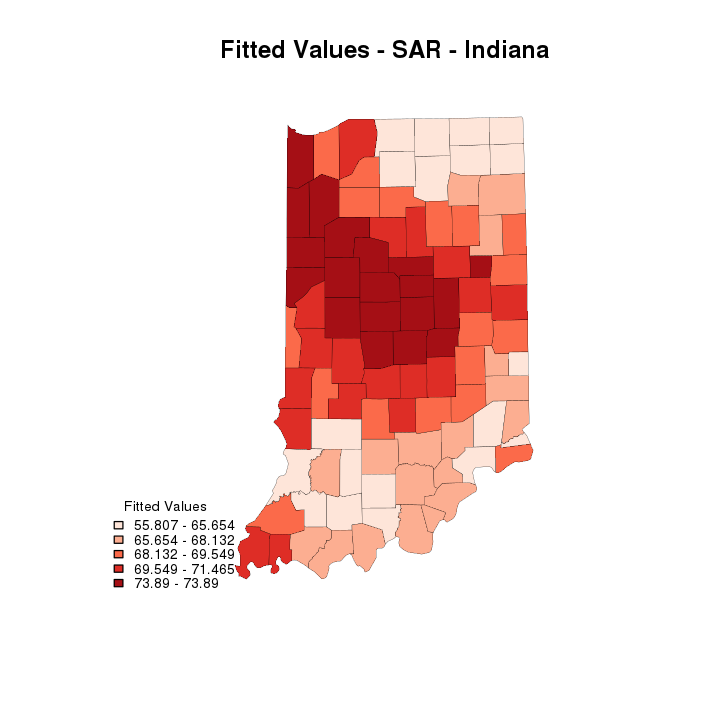

In [625]:
numcat <- 5
cate <- classIntervals(backfitted, numcat, style = "quantile")
pal <- brewer.pal(numcat, "Reds")
cols <- findColours(cate, pal)

plot(ag_in, col = cols, lwd = 0.2, main = "Fitted Values - SAR - Indiana")
brks <- round(cate$brks, 3)
leg <- paste(brks[-numcat], brks[-1], sep = " - ")
legend("bottomleft", fill = pal, legend = leg, bty = "n", title = "Fitted Values", cex = 0.7)

In [626]:
corr <- cor(y.Y_Var, Ex_Var)
paste("Pearson Correlation: ", corr)

[1] "Pearson Correlation:  0.101126068274654"

**JACKY**: Terrible!

In [627]:
Y_Var_Sar2 <- errorsarlm(y.Y_Var ~ 1, listw = ag_in.nb.listw)
summary(Y_Var_Sar2)


Call:errorsarlm(formula = y.Y_Var ~ 1, listw = ag_in.nb.listw)

Residuals:
      Min        1Q    Median        3Q       Max 
-1.465571 -0.053703  0.033184  0.106368  0.282586 

Type: error 
Coefficients: (asymptotic standard errors) 
            Estimate Std. Error z value  Pr(>|z|)
(Intercept) 4.083355   0.047105  86.686 < 2.2e-16

Lambda: 0.49307, LR test value: 13.572, p-value: 0.00022962
Asymptotic standard error: 0.11864
    z-value: 4.1559, p-value: 3.2402e-05
Wald statistic: 17.271, p-value: 3.2402e-05

Log likelihood: 2.46679 for error model
ML residual variance (sigma squared): 0.052459, (sigma: 0.22904)
Number of observations: 92 
Number of parameters estimated: 3 
AIC: 1.0664, (AIC for lm: 12.638)


In [628]:
paste("Lambda of SAR Y: ", Y_Var_Sar2$lambda)

[1] "Lambda of SAR Y:  0.4930728921219"

<b style="color: red;">JACKY: Lambda is statistically signicant. This indicates that there is spatial autocorrelation at work for this variable </b>

In [629]:
Ex_Var_Sar <- errorsarlm(Ex_Var ~ 1, listw = ag_in.nb.listw)
summary(Ex_Var_Sar)

Warning message in errorsarlm(Ex_Var ~ 1, listw = ag_in.nb.listw):
“inversion of asymptotic covariance matrix failed for tol.solve = 1e-10 
  reciprocal condition number = 1.05152e-12 - using numerical Hessian.”


Call:errorsarlm(formula = Ex_Var ~ 1, listw = ag_in.nb.listw)

Residuals:
        Min          1Q      Median          3Q         Max 
-5.8523e-04 -3.5981e-04 -2.9989e-04  1.1882e-05  8.3447e-03 

Type: error 
Coefficients: (asymptotic standard errors) 
              Estimate Std. Error z value  Pr(>|z|)
(Intercept) 0.00051077 0.00013846  3.6889 0.0002252

Lambda: 0.23895, LR test value: 2.4295, p-value: 0.11907
Approximate (numerical Hessian) standard error: 0.1489
    z-value: 1.6047, p-value: 0.10855
Wald statistic: 2.5752, p-value: 0.10855

Log likelihood: 503.443 for error model
ML residual variance (sigma squared): 1.0216e-06, (sigma: 0.0010107)
Number of observations: 92 
Number of parameters estimated: 3 
AIC: -1000.9, (AIC for lm: -1000.5)


In [630]:
paste("Lambda of SAR X:", Ex_Var_Sar$lambda)

[1] "Lambda of SAR X: 0.238950028758881"

<b style="color: red;">JACKY: Lambda is statistically insignicant.</b>

In [631]:
# adjust the variables for spatial autocorrelation

Y_Var_sa <- y.Y_Var - Y_Var_Sar2$lambda * lag.listw(ag_in.nb.listw, y.Y_Var)
Ex_Var_sa <- Ex_Var - Ex_Var_Sar$lambda * lag.listw(ag_in.nb.listw, Ex_Var)

In [632]:
# recalculate the correlation

paste("Adjusted Correlation: ", cor(Y_Var_sa, Ex_Var_sa))

[1] "Adjusted Correlation:  0.0361744331670561"

**JACKY**: The correlation actually dropped with the adjustments. This is not surprising at all because I knew from the beginning that the CrashesPerAcre has absolutely nothing to do with Irrigation. However, it was a fun practice for me. 

**Task 15:** Dataset 3 Analysis

<div style="color:red">** JACKY **: I attempt to cluster areas with high crash freqencies </div>

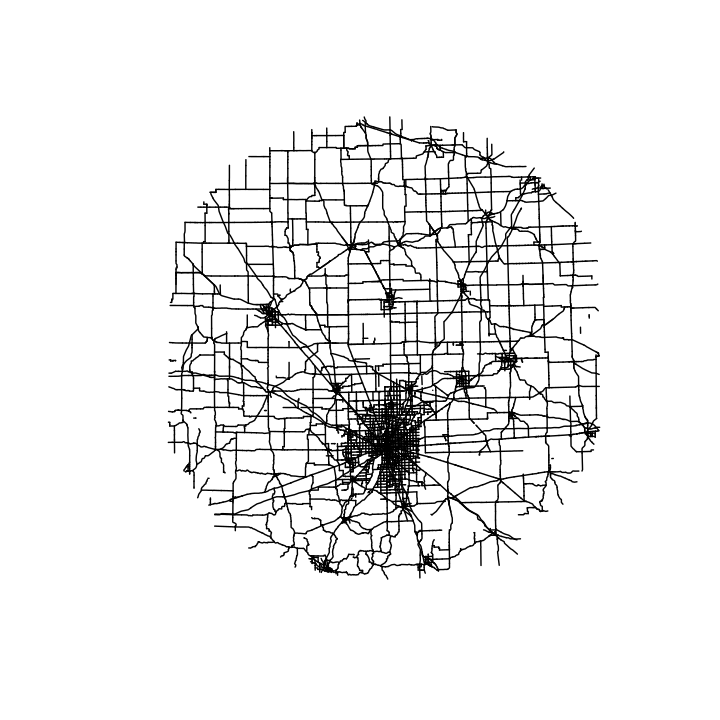

In [633]:
plot(roadBuffer)

In [634]:
head(roadBuffer@data)

,YEAR_RECOR,STATE_CODE,BEG_POINT,END_POINT,F_SYSTEM,URBAN_CODE,FACILITY_T,THROUGH_LA,AADT,VOLUME_GRO,⋯,RouteID,FrMeasure,ToMeasure,SideOfRoad,Length,LENGTHMETER,road.id,NumCrash,LENGTHMILE,crash.frq
0,2012,18,11.311,12.570,5,99999,2,4,6534,4,⋯,401,8781.3,15450.8,L,6669.48945,2032.122,1,NA,1.262972140,0.000000
2,2012,18,15.590,16.570,1,41212,2,6,105514,9,⋯,43,57313.5,62575.0,L,5261.47960,1603.097,2,10,0.996330996,10.036825
3,2012,18,3.020,4.000,4,99999,2,2,3584,3,⋯,46087,0.0,5174.5,R,5174.49719,1576.566,3,NA,0.979842093,0.000000
5,2012,18,6.187,6.425,1,99999,2,4,47444,7,⋯,9,103976.6,105234.0,R,1257.37911,383.1085,4,NA,0.238103494,0.000000
7,2012,18,2.600,2.610,1,99999,2,4,30266,6,⋯,17,48422.2,48474.8,R,52.51993,16.02642,5,4,0.009960485,401.586860
8,2012,18,0.000,8.650,4,99999,2,2,2404,3,⋯,39213,0.0,2557.2,R,2557.22233,779.1458,6,2,0.484242254,4.130164


In [635]:
road.nb <- poly2nb(roadBuffer, queen = TRUE)
road <- roadBuffer[card(road.nb) >= 1, ]

road.nb <- poly2nb(road, queen = TRUE)
road.listb <- nb2listw(road.nb, style = "B")
road.listw <- nb2listw(road.nb, style = "W")

road.self <- include.self(road.nb)
road.self.listb <- nb2listw(road.self, style = "B")
road.self.listw <- nb2listw(road.self, style = "W")

In [636]:
crashFreq <- road@data$crash.frq
totalMiles <- road@data$LENGTHMILE

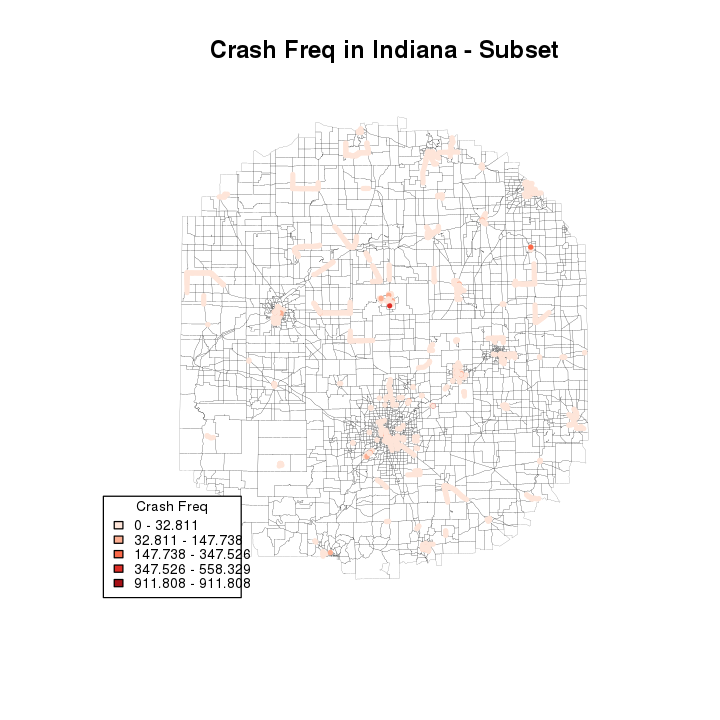

In [637]:
numcat <- 5
cate <- classIntervals(crashFreq, numcat, style = "jenks")
pal <- brewer.pal(numcat, "Reds")
cols <- findColours(cate, pal)

plot(tranzones.subset, lwd = 0.1, main = "Crash Freq in Indiana - Subset")
plot(road, border = cols, lwd = 4, add = TRUE)

brks <- round(cate$brks, 3)
leg.text <- paste(brks[-numcat], brks[-1], sep = " - ")
legend("bottomleft", fill = attr(cols, "palette"), legend = leg.text, title = "Crash Freq", cex = 0.7)

In [638]:
# compute the local moran statistic

LM <- localmoran(crashFreq, road.listw, alternative = "two.sided")
head(LM)

,Ii,E.Ii,Var.Ii,Z.Ii,Pr(z != 0)
18,0.02212894,-0.0008650519,0.7135895,0.02722013,0.9782842
61,0.02212894,-0.0008650519,0.7135895,0.02722013,0.9782842
65,0.02212894,-0.0008650519,0.7135895,0.02722013,0.9782842
66,0.02212894,-0.0008650519,0.7135895,0.02722013,0.9782842
80,-0.01667326,-0.0008650519,0.7135895,-0.01871365,0.9850695
83,0.02212894,-0.0008650519,0.7135895,0.02722013,0.9782842


In [639]:
zScore <- LM[, c("Z.Ii")]
pValue <- LM[, c("Pr(z != 0)")]

In [640]:
g <- localG(crashFreq, road.self.listb)


head(g)

[1] -0.21046664 -0.21046664 -0.21046664 -0.21046664 -0.02594427 -0.21046664

In [641]:
# compute the z-scores 

zNormal <- list()

probsU <- c(0.90, 0.95)

i <- 1

for (pr in probsU){
    # convert confidence levels to sig probs
    inpr <- 1 - ((1-pr)/2)
    
    # compute normal error for z-score
    errorZ <- qnorm(inpr, lower.tail = TRUE)
    zNormal[[i]] <- 0 + errorZ
    i <- i + 1
}

In [642]:
zG <- unlist(zNormal)
paste(probsU, zG, sep = " => ")

[1] "0.9 => 1.64485362695147"  "0.95 => 1.95996398454005"

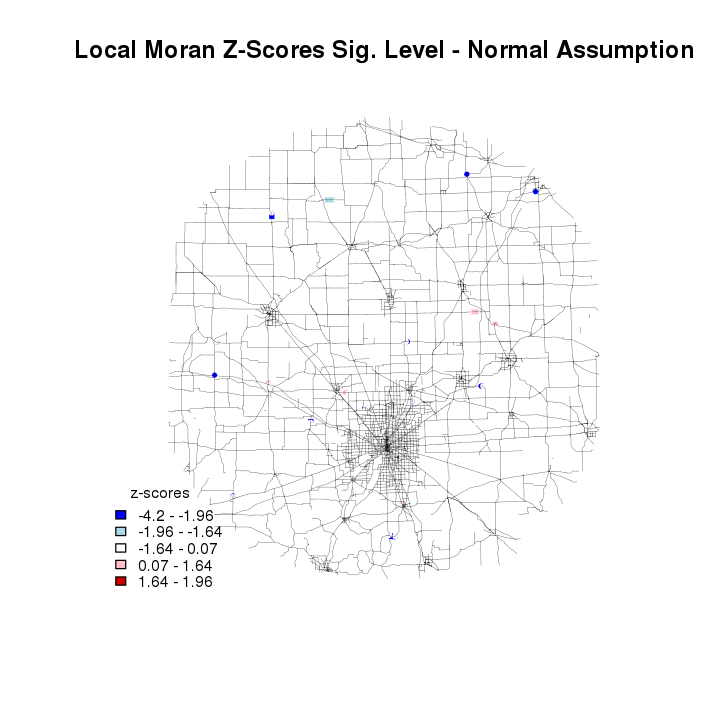

In [643]:
ncz1 <- 4 + length(zG) - 1
ncz2 <- 4 + length(zG)

z.Mi <- classIntervals(zScore, n = ncz1, style = "fixed", fixedBreaks = c(min(zScore), -zG, zG, max(zScore)))
pal <- c("blue", "lightblue", "white", "pink", "red3")
cols.m <- findColours(z.Mi, pal)

plot(roadBuffer, border = cols.m, lwd = 4, main = "Local Moran Z-Scores Sig. Level - Normal Assumption")
plot(roadBuffer, lwd = 0.1, add = TRUE)
brks <- round(z.Mi$brks, 2)
leg <- paste(brks[-ncz2], brks[-1], sep = " - ")
legend("bottomleft", fill = pal, legend = leg, bty = "n", title = "z-scores", cex = 0.8)

## ANALYSIS SUMMARY

Provide a detailed summary of modeling processes you applied as well as the analytical results that were obtained.

**Summary 1:** Dataset 1 - Discuss the modeling process you applied/implemented as well as the results of the analysis

**Summary 2:** Dataset 2 - Discuss the modeling process you applied/implemented as well as the results of the analysis

**Summary 3:** Dataset 3 - Discuss the modeling process you applied/implemented as well as the results of the analysis

# SAVE YOUR NOTEBOOK